<a href="https://colab.research.google.com/github/Mochismo/LearnPython/blob/main/ObjectDetectionc_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

trainX.shape (4816, 32, 32)
trainY.shape (4816,)
testX.shape (536, 32, 32)
testY.shape (536,)
[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 20)       80        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 50)        25050     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 10, 50)       200       
 hNormalization)                                                 
                                                        

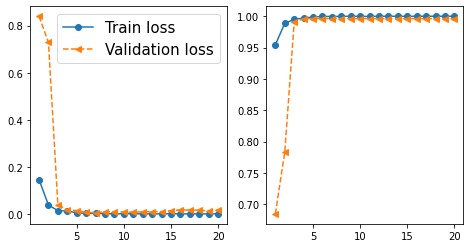

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 30 11:39:37 2020

@author: scholar1
"""
#from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from imutils import build_montages
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import sys

from mlxtend.plotting import plot_decision_regions
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 20
INIT_LR = 1e-2
BS = 32

def build_model(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = tf.keras.models.Sequential()
	inputShape = (height, width, depth)
	chanDim = -1

	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1

	# first CONV => RELU => CONV => RELU => POOL layer set
	model.add(tf.keras.layers.Conv2D(20, (5, 5), padding="valid", activation="relu", input_shape=inputShape))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
	model.add(tf.keras.layers.Conv2D(50, (5, 5), padding="valid", activation="relu"))
	model.add(tf.keras.layers.BatchNormalization(axis=chanDim))
	model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

	# first (and only) set of FC => RELU layers
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(500, activation="relu"))
	model.add(tf.keras.layers.BatchNormalization())
	
	# softmax classifier
	model.add(tf.keras.layers.Dense(classes, activation="softmax"))

	# return the constructed network architecture
	return model


def get_all_images_for_label(label, X, Y):	
	img_paths = glob.glob(os.path.join("/content/drive/MyDrive/video1/training", label, "*.png"))
	for img_path in img_paths:
		X.append(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
	if label != "background":
		Y.extend(int(label) for i in range(len(img_paths)))

	else:
		Y.extend(4 for i in range(len(img_paths)))
#data_dir = "video1/"
#annotation_3d_points = np.array(read_point_file(os.path.join(data_dir, "markers3dPoints.txt")))

X = []
Y = []

get_all_images_for_label("0", X, Y)
get_all_images_for_label("1", X, Y)
get_all_images_for_label("2", X, Y)
get_all_images_for_label("3", X, Y)
get_all_images_for_label("background", X, Y)

# convert from python list to numpy array
X = np.array(X)
Y = np.array(Y) 

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1, shuffle= True)

print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape) 
print("testY.shape", testY.shape) 

img_width = trainX[0].shape[1]
img_height = trainX[0].shape[0]


# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# 	num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	trainX = trainX.reshape((trainX.shape[0], 1, img_width, img_height))
	testX = testX.reshape((testX.shape[0], 1, img_width, img_height))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	trainX = trainX.reshape((trainX.shape[0], img_width, img_height, 1))
	testX = testX.reshape((testX.shape[0], img_width, img_height, 1))
 
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

num_classes = 5

# one-hot encode the training and testing labels
trainY = tf.keras.utils.to_categorical(trainY, num_classes)
testY = tf.keras.utils.to_categorical(testY, num_classes)

labelNames = ["0 ", "1", "2", "3", "background"]




# initialize the optimizer and model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = build_model(width=img_width, height=img_height, depth=1, classes=num_classes)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print(model.summary())

# train the network
print("[INFO] training model...")
H = model.fit(trainX, trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

model.save('model_part_detection.h5')  # creates a HDF5 file 'my_model.h5'

hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend (fontsize=15)
ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<',
        label='Validation acc.')
#ax.legend(fontsize=15)
#ax = fig.add_subplot(1, 3, 3)
#plot_decision_regions(X= testX, clf=model)
#ax.set_xlabel(r'$x_1$', size=15)
#ax.xaxis.set_label.coords(1, -0.025)
#ax.set_ylabel(r'$x_2$', size=15)
#ax.yaxis.set_label.coords(-0.025, 1)
plt.show()